In [ ]:
 # 1. Подключение нужных библиотек
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
import statistics
import datetime
import matplotlib.pyplot as plt
from bokeh.plotting import figure, output_file, show
from bokeh.io import output_notebook
# Проанализируем содержимое кода страницы и извлечём из неё нужные данные. Так как в данный момент в открытом доступе только информация о частоте и температуре энергостанций,
# используем именно эти данные
def create_url_freq(date):
  url_begin = "https://so-ups.ru/functioning/ees/ees-indicators/ees-freq/?tx_mscdugraph_pi%5Bcontroller%5D=Graph&tx_mscdugraph_pi%5Baction%5D=fullview&tx_mscdugraph_pi%5BviewDate%5D="
  url_end = "&tx_mscdugraph_pi%5BviewKpo%5D=6100"
  return url_begin + date + url_end

def create_url_temp(date):
  url_begin = "https://so-ups.ru/functioning/ees/ees-indicators/ees-temperature/?tx_mscdugraph_pi%5Bcontroller%5D=Graph&tx_mscdugraph_pi%5Baction%5D=fullview&tx_mscdugraph_pi%5BviewDate%5D="
  url_end = "&tx_mscdugraph_pi%5BviewKpo%5D=6100"
  return url_begin + date + url_end

def parse_consumption(date):
  url = create_url_freq(date)
  soup = BeautifulSoup(requests.get(url).content, 'html.parser')
  full_txt = str(soup)
  text_list_datetime = full_txt[full_txt.find('data-datax=') + len('data-datax=') + 1 : full_txt.find('data-datay=') - 2].split(',')
  text_list_freq = full_txt[full_txt.find('data-datay=') + len('data-datay=') + 1 : full_txt.find('data-date=') - 2].split(',')

  new_date = datetime.datetime.strptime(date, "%Y-%m-%d").date()
  new_date += datetime.timedelta(days=1)
  url = create_url_temp(new_date.strftime("%Y-%m-%d"))
  soup = BeautifulSoup(requests.get(url).content, 'html.parser')
  full_txt = str(soup)
  text_list_date = full_txt[full_txt.find('data-datax=') + len('data-datax=') + 1 : full_txt.find('data-datay=') - 2].split(',')
  text_list_temp = full_txt[full_txt.find('data-datay=') + len('data-datay=') + 1 : full_txt.find('data-date=') - 2].split(',')

  df = pd.DataFrame([text_list_datetime, list(map(float, text_list_freq)), [text_list_temp[text_list_date.index(date + ' 0:00')]] * len(text_list_freq)])
  return df.T
# Возьмём данные за последние 3 дня и склеим их в одну таблицу
df_power = parse_consumption('2023-06-07')
df_power = pd.concat([df_power, parse_consumption('2023-06-06')], axis=0, ignore_index = True)
df_power = pd.concat([df_power, parse_consumption('2023-06-05')], axis=0, ignore_index = True)
df_power
# Переименуем столбцы
df_power_2 = df_power.copy()

df_power_2.columns = ['Период', 'Частота, Гц', 'Температура, *C']

# Установим время в качестве метки строки
df_power_2 = df_power_2.set_index('Период')

# Явно укажем, что данные - числа с плавающей запятой (float)
df_power_2['Частота, Гц'] = df_power_2['Частота, Гц'].astype('float')
df_power_2['Температура, *C'] = df_power_2['Температура, *C'].astype('float')

df_power_2
#Cортировка по возрастанию по столбцу "Период"
df_power_2 = df_power_2.sort_values(['Период'], ascending = False)
print(df_power_2)
# Добавление столбца с проверкой на уровень частоты
df_power_2['Уровень частоты'] = np.where(df_power_2['Частота, Гц'] < 50, 'Ниже нормы', np.where(df_power_2['Частота, Гц'] > 50, 'Выше нормы', 'Норма'))
df_power_2
# Добавление столбца с проверкой на уровень температуры
#df_power_2['Температура, гр.C'] = np.where(df_power_2['Температура, гр.C'] < 17.7, 'Пониженный', np.where(df_power_2['Температура, гр.C'] >17.7 , 'Повышенный', 'Нормированный'))
#df_power_2
#Вопрос можно было сделать проверку на уровень температуры , но мы ведь точно не можем сказать точный уровень, который определяет , повышена она ли понижена , т.к у каждого предприятия эта цифра своя, так вот вопрос это как то вообще можно сделать?
# Выборка данных по условию
# Выборка данных с температурой выше 17.7 градусов по Цельсию.
print(df_power_2[df_power_2['Температура, *C'] > 17.7])
print('Выборка данных')
print()

# Выборка данных с частотой ниже 50 Гц.
print(df_power_2[df_power_2['Частота, Гц'] < 50.])
print() 

# Выборка данных с нормированным уровнем частоты
print(df_power_2[df_power_2['Уровень частоты'] == 'Норма'])
print() 

# Выборка данных с частотой выше 50.01 Гц. и температурой ниже 17.5 градусов по Цельсию.
print(df_power_2[(df_power_2['Частота, Гц'] > 50.01) & (df_power_2['Температура, *C'] < 17.5)])
print() 
#Берём 50.01 , т.к это более усреднённое значение , а если взять другие , то таблицы будут выглядет не очень.
print('данные из 1 строки и столбца 1')
print(df_power_2.iloc[1,1])
print()
print('данные из всех строк кроме десяти последних и из столбцов с первого по шестой включительно ')
print(df_power_2.iloc[: -10, 2 : 7])
print()
print('Данные из нечетных строк и первого   столбца:')
print(df_power_2.iloc[ : : 2, 1])
print()
#print('все данные из строки \'1\'')
#print(df_exted_2.iloc[1 ])
#print(df_exted_2.iloc[1,0 ])
#print()
#print('все данные из строки \16\'')
#print(df_exted_2.loc[['16']])
#print()
#Вопрос: можно ли как-то через iloc взять данные всей строки?Выше написал, способы , но они не работают, понимаешь, что нужно взять и обозначить , как-то первую строчку, но будет ли работать тогда iloc?

                  Частота, Гц  Температура, *C
Период                                        
2023-06-07 9:00         50.01            17.77
2023-06-07 8:00         50.00            17.77
2023-06-07 7:00         50.01            17.77
2023-06-07 6:00         50.00            17.77
2023-06-07 5:00         50.01            17.77
...                       ...              ...
2023-06-05 13:00        49.99            17.18
2023-06-05 12:00        50.02            17.18
2023-06-05 11:00        50.00            17.18
2023-06-05 10:00        49.99            17.18
2023-06-05 0:00         49.98            17.18

[69 rows x 2 columns]
                  Частота, Гц  Температура, *C Уровень частоты
Период                                                        
2023-06-07 9:00         50.01            17.77      Выше нормы
2023-06-07 8:00         50.00            17.77           Норма
2023-06-07 7:00         50.01            17.77      Выше нормы
2023-06-07 6:00         50.00            17.77     

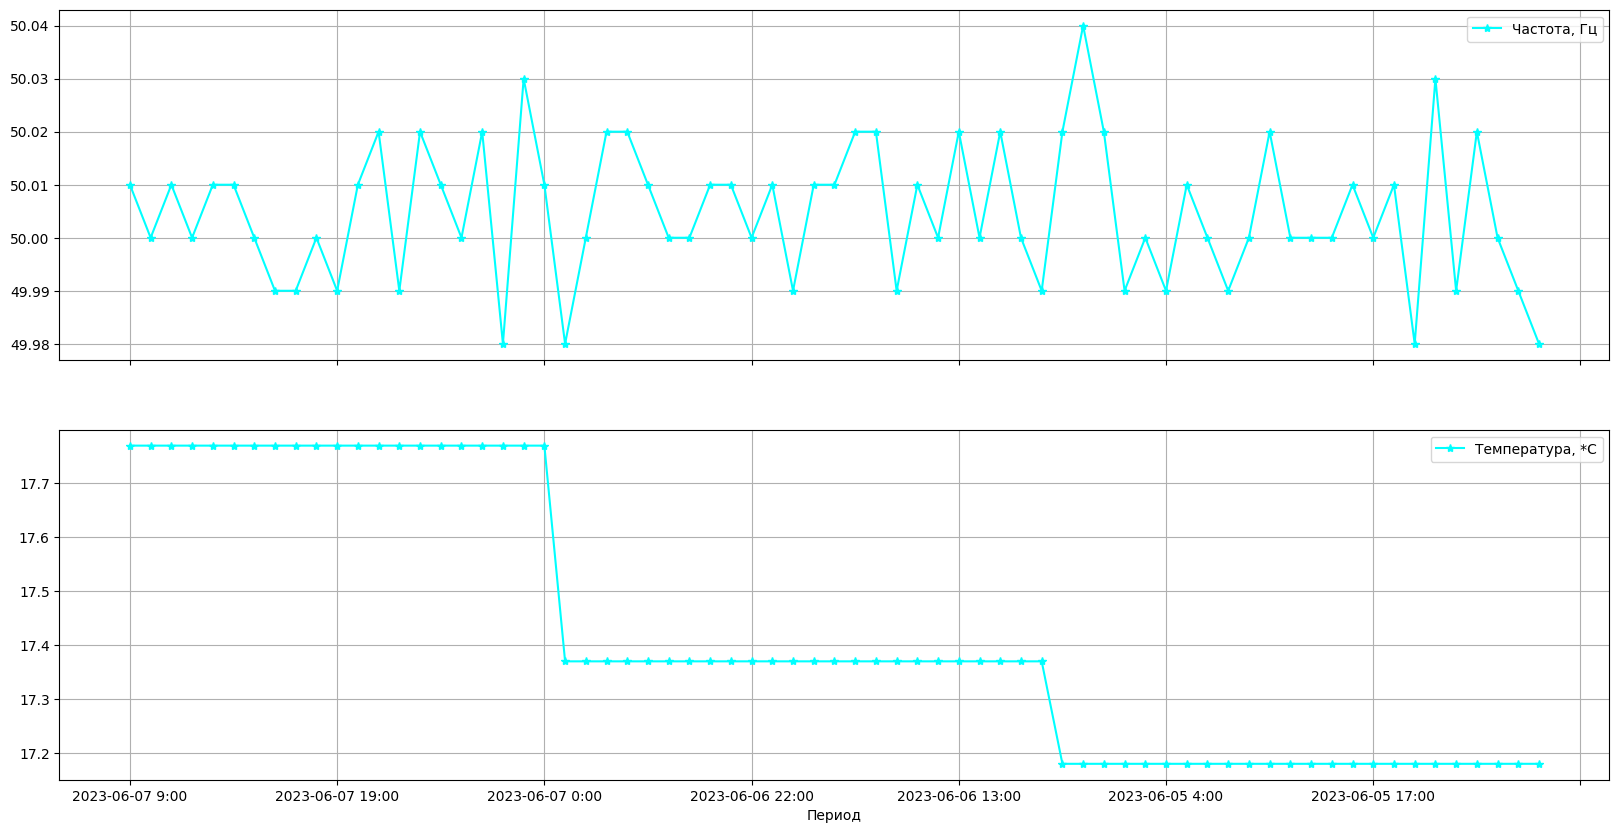

In [ ]:
# Построим графики
axes = df_power_2.plot(marker='*', figsize=(20, 10), subplots = True, color='cyan')

for _ in axes:
  _.grid(True)

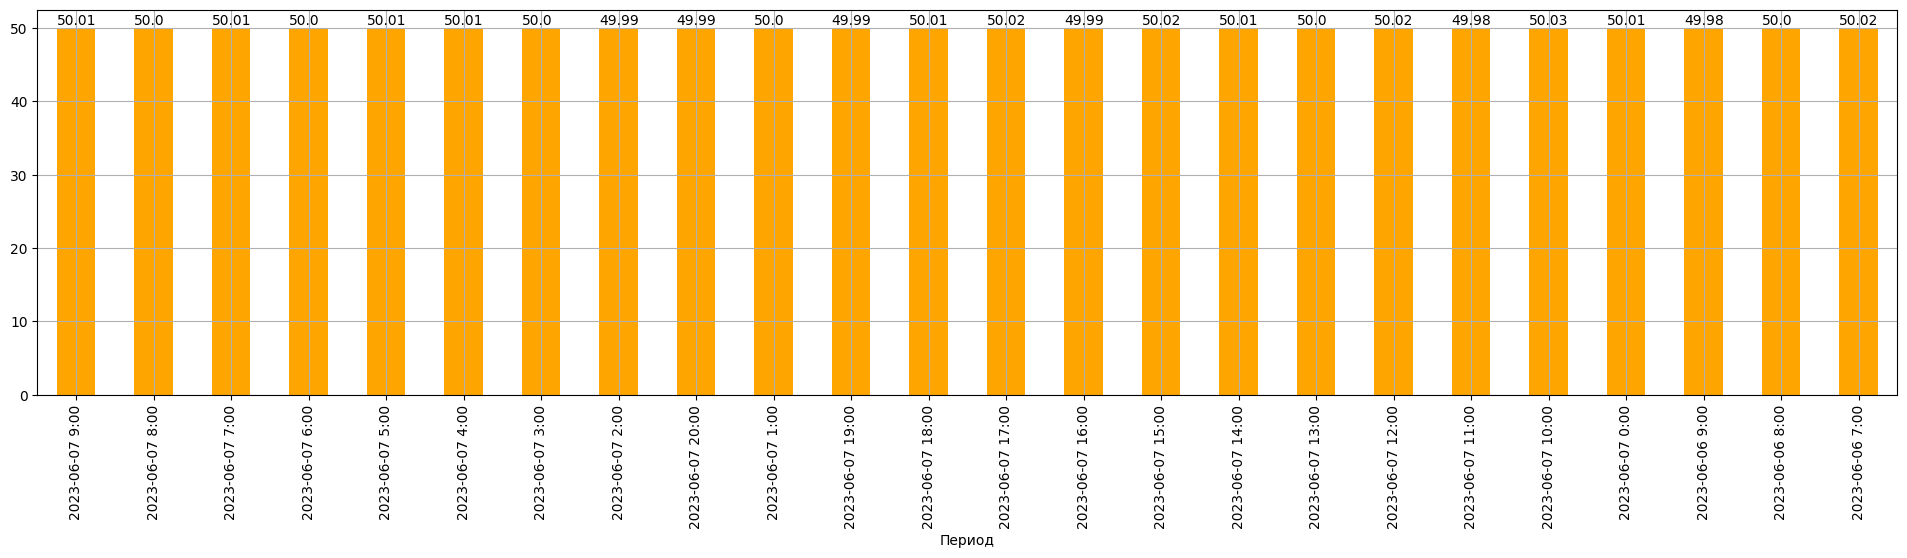

In [ ]:
# Гистограмма
axes = df_power_2.iloc[ : 24, 0].plot(kind = 'bar', figsize=(24, 5), color = 'orange')

# Добавим точные значения каждому столбцу
for p in axes.patches:
  axes.annotate(str(p.get_height()), (p.get_x(), p.get_height() * 1.01))

axes.grid(True)

In [ ]:
# Вывелем корреляцию
df_power_2.corr()

<ipython-input-75-a001b1bf6786>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_power_2.corr()


,"Частота, Гц","Температура, *C"
"Частота, Гц",1.00000,0.02109
"Температура, *C",0.02109,1.00000


<Axes: xlabel='Частота, Гц'>

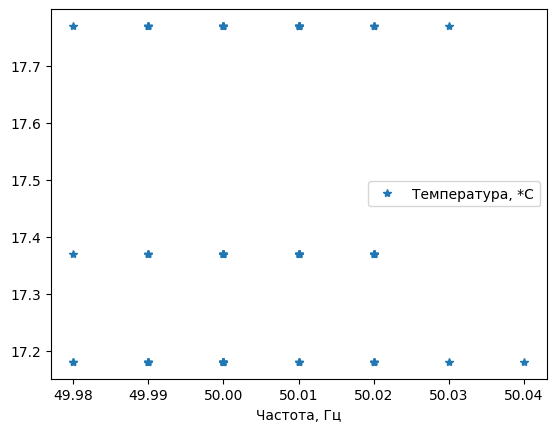

In [ ]:
# Выведем точечные графики, показывающие зависимости величин
df_power_2.plot(x = 'Частота, Гц', y = 'Температура, *C', style='*')
# Само собой данные несколько странные, так как нет смысла выводить графики зависимости частоты от температуры

In [ ]:
# Считаем данные из Excel-файла, полученного с сайта https://minenergo.gov.ru/activity/statistic
# Данные взяты немного старые, так как по ссылке в данный момент ведутся технические работы и получить свежий список не удаётся
df_init = pd.read_excel('https://drive.google.com/uc?export=download&id=1IFULWv72kGpZRDRpqRskm5NIM6AOCFPR', header = None)
df_init

,0,1
0,01.01.2013,103256.7
1,01.02.2013,91532.6
2,01.03.2013,97809.1
3,01.04.2013,85131.0
4,01.05.2013,79080.8
...,...,...
79,01.08.2019,83100.0
80,01.09.2019,84000.0
81,01.10.2019,93200.0
82,01.11.2019,98900.0


In [ ]:
# Выведем график по данным
axes = df_init.plot(marker='.', figsize=(20, 5), subplots = False)
axes.grid(True)

NameError: ignored

In [ ]:
# Разделим в строке дни, месяца и года
df_date = df_init[0].str.split('.', expand = True) 

# Создадим новую таблицу
df_gen = pd.DataFrame()

# Добавим в новую таблицу данные
df_gen['Выработка, МВт*час'] = df_init[1] / 1000 # перевод кВтч в МВтч
df_gen['Номер месяца'] = df_date[1].astype(int) # указание, что этот столбец хранит уже не строки, а целые числа (int - integer)
df_gen['Год'] = df_date[2].astype(int) 

df_gen

,"Выработка, МВт*час",Номер месяца,Год
0,103.2567,1,2013
1,91.5326,2,2013
2,97.8091,3,2013
3,85.1310,4,2013
4,79.0808,5,2013
...,...,...,...
79,83.1000,8,2019
80,84.0000,9,2019
81,93.2000,10,2019
82,98.9000,11,2019


In [ ]:
# Выведем статистику суммарной генерации по годам, построим гистограмму и круговую диаграмму
year_stat = df_gen.groupby(['Год'])['Выработка, МВт*час'].sum()

print(year_stat)
print()

year_stat.plot(kind = 'bar')
print()

def func(pct, allvalues):
    absolute = int(pct / 100.*np.sum(allvalues))
    return "{:.1f}%\n".format(pct, absolute)

fig, ax = plt.subplots(figsize =(10, 7))
wedges = ax.pie(year_stat, labels = year_stat.index, autopct = lambda pct: func(pct, year_stat))
print()

NameError: ignored

Номер месяца
1     723.8397
2     651.2704
3     674.5821
4     600.4886
5     565.8630
6     535.8456
7     551.4041
8     562.8380
9     567.6702
10    644.9951
11    671.6693
12    724.7463
Name: Выработка, МВт*час, dtype: float64





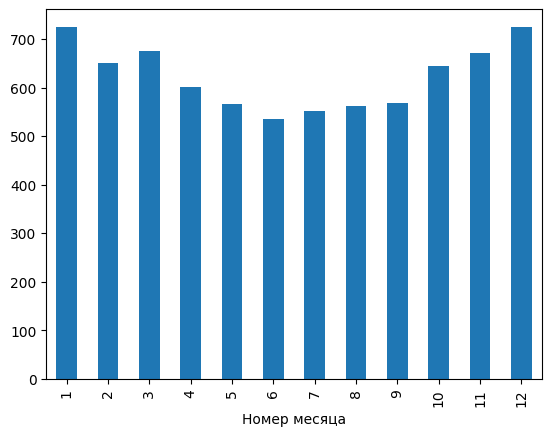

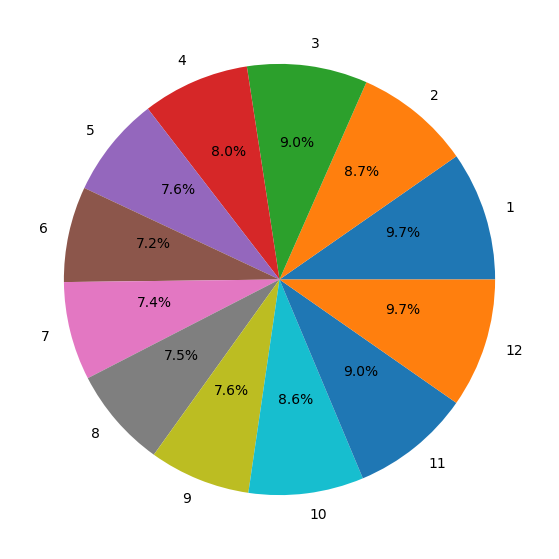

In [ ]:
# Выведем статистику суммарной генерации по месяцам, построим гистограмму и круговую диаграмму
month_stat = df_gen.groupby(['Номер месяца'])['Выработка, МВт*час'].sum()

print(month_stat)
print()

month_stat.plot(kind = 'bar')
print()

def func(pct, allvalues):
    absolute = int(pct / 100.*np.sum(allvalues))
    return "{:.1f}%\n".format(pct, absolute)

fig, ax = plt.subplots(figsize =(10, 7))
wedges = ax.pie(month_stat, labels = month_stat.index, autopct = lambda pct: func(pct, month_stat))
print()

Номер месяца
6     535.8456
7     551.4041
8     562.8380
5     565.8630
9     567.6702
4     600.4886
10    644.9951
2     651.2704
11    671.6693
3     674.5821
1     723.8397
12    724.7463
Name: Выработка, МВт*час, dtype: float64





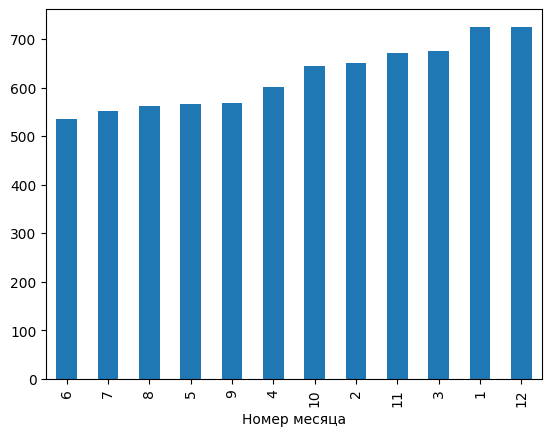

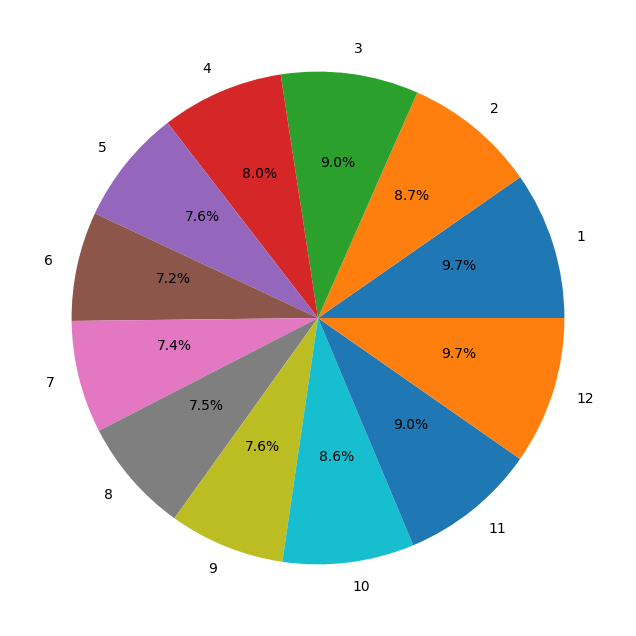

In [ ]:
# Отсортируем данные по возрастанию, построим гистограмму и круговую диаграмму
print(month_stat.sort_values())
print()

month_stat.sort_values().plot(kind = 'bar')
print()

def func(pct, allvalues):
    absolute = int(pct / 100.*np.sum(allvalues))
    return "{:.1f}%\n".format(pct, absolute)

fig, ax = plt.subplots(figsize =(12, 8))
wedges = ax.pie(month_stat, labels = month_stat.index, autopct = lambda pct: func(pct, month_stat))
print()

In [ ]:
# Построим графики помесячной выработки за каждый год 
output_notebook()

p = figure(plot_width = 800, plot_height = 400)

# Список цветов по количеству лет
colors = ['black', 'red', 'yellow', 'green', 'purple', 'blue', 'grey']

# Для каждого года свой график
for year in range(2013, 2020):
  # Выбор из таблицы данных по выработке за нужный год
  values = df_gen[df_gen['Год'] == year]['Выработка, МВт*час'].values 
  
  # Построение линий
  p.line(np.arange(1, 13), values, color = colors[year - 2013], legend_label = str(year), line_width = 3)

  # Построение маркеров
  p.circle(np.arange(1, 13), values, color = colors[year - 2013], alpha=0.5, size = 8)

show(p)